### Proyecto_ARIMA para pronosticar solicitudes de crédito en el siguiente trimestre (T3-2020) 

### Contexto

Una compañia Colombiana requiere pronosticar el volumen de solicitudes de crédito que ingresarán en el proximo mes, con el fin de tomar decisiones que aseguren su eficiencia organizacional.

#### Group # 5

 - Nelson Aldana     - Cod: 201924128
 - Viviana Muñoz     - Cod: 201920081
 - Diego Ojeda       - cod: 201924250

### 1. Alistamiento y Pruebas de estacionalidad 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import read_csv
from matplotlib import pyplot

%matplotlib inline
sns.set()

In [5]:
Ser = pd.read_csv('en_analisis.csv',sep=";",header=0, parse_dates=[0], index_col=0, squeeze=True)
Ser.head()

ds
2018-02-01    18
2018-03-01    13
2018-04-01    20
2018-05-01    17
2018-06-01     0
Name: y, dtype: int64

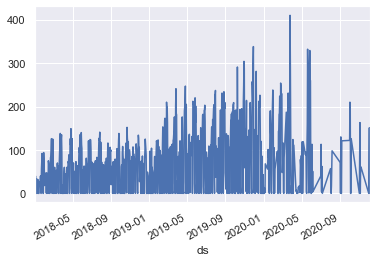

In [153]:
# Grafico de la serie de tiempo
Ser.plot();

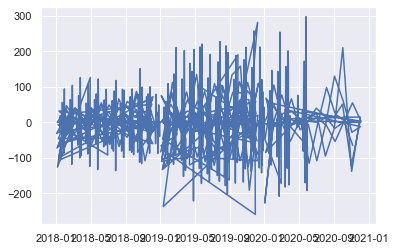

In [154]:
# Grafico de la serie diferenciada
plt.plot(Ser.diff());

In [155]:
# Dickey-Fuller Test (unit root test)

from pandas import read_csv
from statsmodels.tsa.stattools import adfuller

X = Ser.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# El estadistico de prueba = -4.559, por lo que se rechaza la hipotesis nula con un alfa menor al 1%; es decir
# que el proceso no tiene raíz unitari y que la serie temporal es estacionaria.

ADF Statistic: -4.559090
p-value: 0.000154
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


### 2. Correlaciones

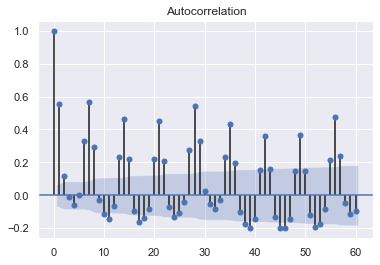

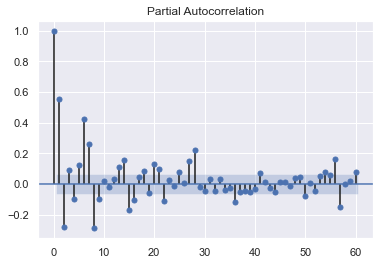

In [156]:
# Autocorrelación y correlación parcial de series 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(Ser, lags=60)
plot_pacf(Ser, lags=60);

In [157]:
# Almacenar la serie difereciada
Ser_diff=Ser.diff()
Ser_diff=Ser_diff[1:892]
Ser_diff=pd.DataFrame(Ser_diff)

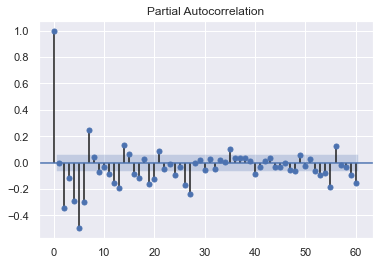

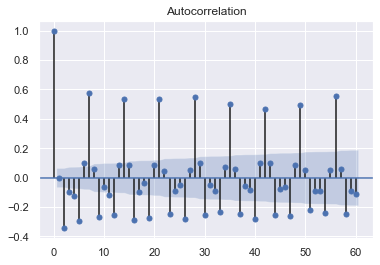

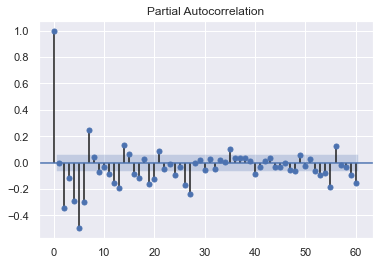

In [158]:
# Graficar correlaciones 
plot_acf(Ser_diff, lags=60)
plot_pacf(Ser_diff, lags=60)

### 3. Modelo ARIMA

In [159]:
# Generamos un grid de evaluacion para obtener los mejores parametros para el modelo ARIMA
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
 
# Se define esta funcion que genera un melo ARIMA, con los argumentos de un dataset y un orden(p,d,q)
def evaluate_arima_model(X, arima_order):
    # Se dividie el dataset en train y test
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Se realizan las predicciones
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Se calcula media del cuadrado del error
    error = mean_squared_error(test, predictions)
    # La funcion retorna el error
    return error
 
# Se define esta funcion que evalua varias combinaciones de p, d y q para un dataset y evalua sus correspondientes modelos ARIMA, y guarda el valor del orden que minimiza el MSE
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
p_values = range(0,8)
d_values = range(0, 2)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(Ser.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=7869.825
ARIMA(0, 0, 1) MSE=4767.251
ARIMA(0, 0, 2) MSE=4524.804
ARIMA(0, 1, 0) MSE=5986.187
ARIMA(0, 1, 1) MSE=6054.889
ARIMA(0, 1, 2) MSE=4920.830
ARIMA(1, 0, 0) MSE=4899.086


In [6]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

model = ARIMA(Ser, order=(7,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  892
Model:                     ARMA(7, 2)   Log Likelihood               -4703.500
Method:                       css-mle   S.D. of innovations             47.096
Date:                Mon, 22 Jun 2020   AIC                           9429.000
Time:                        20:39:45   BIC                           9481.728
Sample:                             0   HQIC                          9449.151
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.6728      5.796     12.711      0.000      62.313      85.032
ar.L1.y        0.3766      0.043      8.780      0.000       0.293       0.461
ar.L2.y       -0.5617      0.100     -5.599      0.000      -0.758      -0.365
ar.

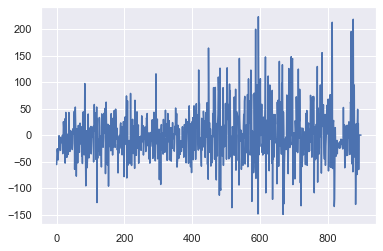

In [9]:
import matplotlib.pyplot as plt

residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals);

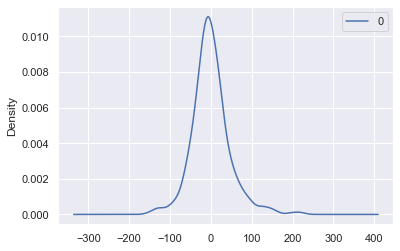

0
count  899.000000
mean     0.091129
std     46.983804
min   -149.602066
25%    -25.500138
50%     -3.866427
75%     20.492366
max    223.188819


In [10]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [13]:
X = Ser.values

history = [x for x in X]

# Definimos la prediccion
predictions = list()

for t in range(1,30):
    model = ARIMA(history, order=(7,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast() #pronostica un solo dato
    yhat = output[0]
    predictions.append(yhat[0])
    history.append(yhat[0])
    print('predicted=%f' % (yhat))

predicted=58.106907
predicted=9.483477
predicted=16.430459
predicted=97.889264
predicted=116.001267
predicted=85.172308
predicted=70.341728
predicted=66.125016
predicted=38.082949
predicted=41.154851
predicted=92.413617
predicted=103.546047
predicted=72.942104
predicted=69.330711
predicted=74.403323
predicted=52.872374
predicted=53.128020
predicted=88.956108
predicted=93.754735
predicted=68.063322
predicted=69.384801
predicted=78.452163
predicted=61.306408
predicted=59.352499
predicted=85.923193
predicted=87.446160
predicted=66.226092
predicted=70.049296
predicted=80.156763


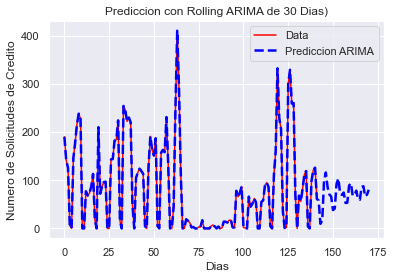

In [16]:
#Graficamos los valores de la prediccion de 30 días hacia adelante

plt.plot(Ser.values[750:],color="red", label='Data')
plt.plot(history[750:],color="blue",linestyle="--",linewidth=2.5, label='Prediccion ARIMA')
plt.title("Prediccion con Rolling ARIMA de 30 Dias)")
plt.xlabel("Dias")
plt.ylabel("Numero de Solicitudes de Credito")
plt.legend();

### 4. Modelos ajustado con Prophet 

In [17]:
# Importamos las librerias necesarias
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


In [18]:
def parser(x):
    return pd.datetime.strptime(x,"%d/%m/%Y")

# Cargamos la base de datos
Ser = pd.read_csv('en_analisis.csv',sep=";",header=0, parse_dates=[0], index_col=0, squeeze=True,date_parser=parser)

Ser = pd.DataFrame({"df":Ser.index,"y":Ser.values})
Ser.head()

,df,y
0,2018-01-02,18
1,2018-01-03,13
2,2018-01-04,20
3,2018-01-05,17
4,2018-01-06,0


In [19]:
# Dividimos la base de datos

X = Ser.values
size = int(len(X) * 0.95)
train, test_pro = X[0:size], X[size:len(X)]
history_Pro = [x for x in train]
predictions_Pro = list()
history_Pro = pd.DataFrame(history_Pro,columns=("ds","y"))

In [20]:
#Generamos el algoritmo de ajuste de los ultimos 45 Dias de los datos con Prophet

for t in range(len(test_pro)):
    model_Pro = Prophet(daily_seasonality=True)
    model_Pro.fit(history_Pro)
    future = model_Pro.make_future_dataframe(periods=t+1, freq='D')
    forecast = model_Pro.predict(future)
    yhat = forecast.yhat.tail(1)
    predictions_Pro.append(yhat)
    obs = test_pro[t]
    ldf = pd.DataFrame([(obs[0],obs[1])],columns=("ds","y"))
    history_Pro = history_Pro.append(ldf, ignore_index=True)
    print("Dato # %f,predicted=%f, expected=%f" % (t,yhat, obs[1]))

Dato # 0.000000,predicted=101.781933, expected=66.000000
Dato # 1.000000,predicted=106.261920, expected=74.000000
Dato # 2.000000,predicted=13.641481, expected=87.000000
Dato # 3.000000,predicted=90.376119, expected=2.000000
Dato # 4.000000,predicted=110.415627, expected=1.000000
Dato # 5.000000,predicted=105.882120, expected=0.000000
Dato # 6.000000,predicted=6.247598, expected=66.000000
Dato # 7.000000,predicted=110.621973, expected=45.000000
Dato # 8.000000,predicted=108.076599, expected=51.000000
Dato # 9.000000,predicted=10.431054, expected=62.000000
Dato # 10.000000,predicted=85.300238, expected=54.000000
Dato # 11.000000,predicted=104.038602, expected=0.000000
Dato # 12.000000,predicted=100.684146, expected=0.000000
Dato # 13.000000,predicted=-1.775943, expected=55.000000
Dato # 14.000000,predicted=100.128493, expected=58.000000
Dato # 15.000000,predicted=101.437501, expected=89.000000
Dato # 16.000000,predicted=4.592138, expected=95.000000
Dato # 17.000000,predicted=79.215875, 

In [21]:
# Convertimos los resultados en variables graficables
pred_prob = list()
for i in range(len(predictions_Pro)):
    pred_prob.append(predictions_Pro[i].values)

test_pro = test_pro[:,1]

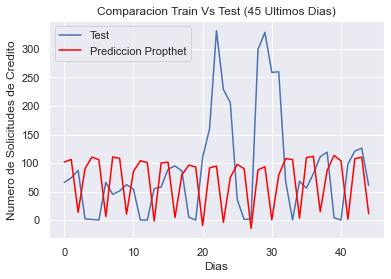

In [22]:
plt.plot(test_pro, label='Test')
plt.plot(pred_prob, color = "red", label='Prediccion Propthet')
plt.title("Comparacion Train Vs Test (45 Ultimos Dias)")
plt.xlabel("Dias")
plt.ylabel("Numero de Solicitudes de Credito")
plt.legend();

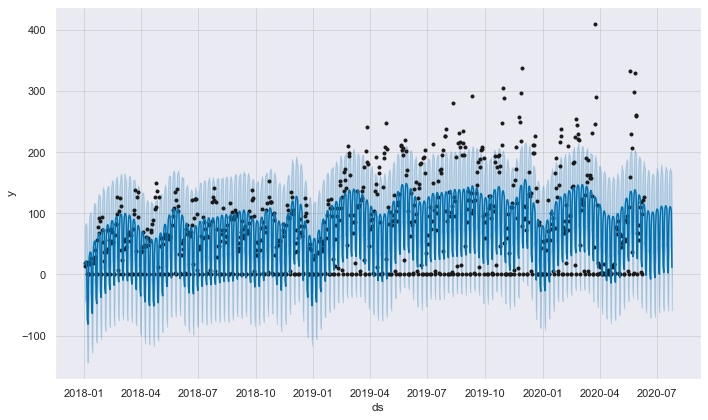

In [23]:
fig1 = model_Pro.plot(forecast)

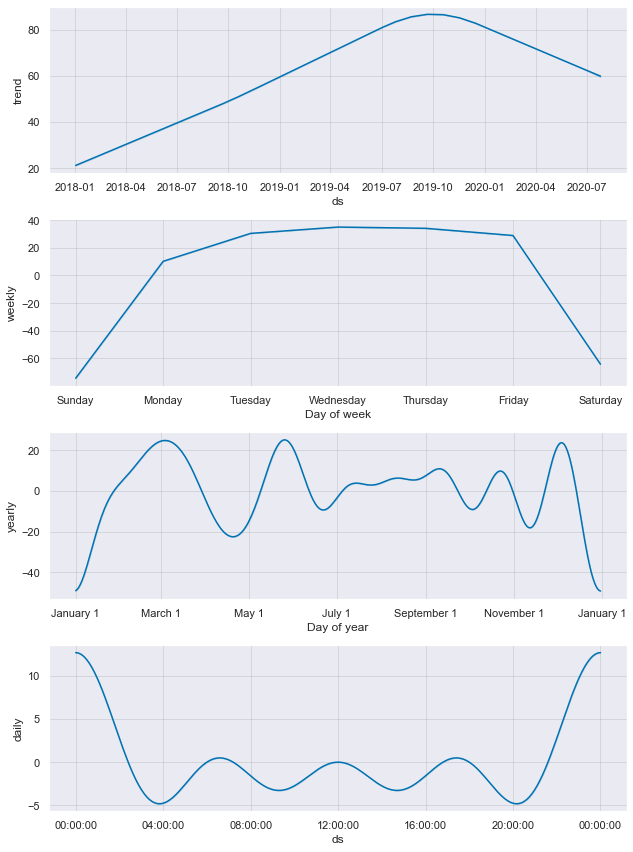

In [24]:
# Revisamos la tendencia general
model_Pro.plot_components(forecast);

Generaremos la prediccion para los proximos 30 Dias

In [25]:
# Tomamos valores de la serie (solo valores)
X = Ser.values
size = int(len(X) * 1)
train = X[0:size]
history_Pro = [x for x in train]
predictions_Pro = list()
history_Pro = pd.DataFrame(history_Pro,columns=("ds","y"))

In [26]:
#Generamos el algoritmo de Rolling con Prophet

for t in range(1,31):
    model_Pro = Prophet(daily_seasonality=True)
    model_Pro.fit(history_Pro)
    future = model_Pro.make_future_dataframe(periods=t, freq='D')
    forecast = model_Pro.predict(future)
    yhat = forecast.yhat.tail(1)
    ts=pd.to_datetime(str(future.values[-1][0]))
    d = ts.strftime('%Y-%m-%d')
    ldf = pd.DataFrame([(d,yhat.values[0])],columns=("ds","y"))
    predictions_Pro.append(yhat.values[0])
    history_Pro = history_Pro.append(ldf, ignore_index=True)
    print('predicted=%f' % (yhat))


predicted=101.904979
predicted=-3.555986
predicted=101.216967
predicted=-10.232123
predicted=93.258274
predicted=104.995043
predicted=109.952668
predicted=104.675285
predicted=1.594271
predicted=109.580526
predicted=2.869705
predicted=102.319214
predicted=111.668244
predicted=97.543421
predicted=87.182350
predicted=-3.850121
predicted=77.037222
predicted=5.316490
predicted=68.368048
predicted=49.204815
predicted=87.943095
predicted=98.869643
predicted=-3.072046
predicted=69.264100
predicted=-42.448038
predicted=95.770358
predicted=67.159833
predicted=78.564060
predicted=72.888426
predicted=-33.049093


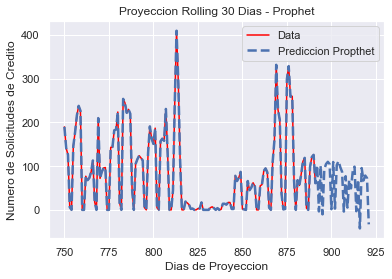

In [27]:
plt.plot(Ser.y[750:],color="red", label='Data')
plt.plot(history_Pro.y[750:],linestyle="--",linewidth=2.5, label='Prediccion Propthet');
plt.title("Proyeccion Rolling 30 Dias - Prophet")
plt.xlabel("Dias de Proyeccion")
plt.ylabel("Numero de Solicitudes de Credito")
plt.legend();
